# ＜3層ニューラルネット＞

## 手書き文字のデータセット
___________  

|データ|ファイル名|
|:----|:----|
|筆記者0のテストデータ|hira0_00T.dat ~ hira0_19T.dat|
|筆記者1のテストデータ|hira1_00T.dat ~ hira1_19T.dat|
|筆記者0の学習データ|hira0_00L.dat ~ hira0_19L.dat|
|筆記者1の学習データ|hira1_00L.dat ~ hira1_19L.dat|


In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
np.set_printoptions(threshold=10000)

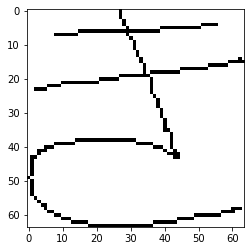

In [2]:
p = Path('Data')
d = list(p.glob("**/*.dat"))[5]
data = []
f = open(d, 'r')
for line in f:
    data.append([ int(num) for num in line.rstrip('\n') ])
data = np.array(data)

plt.imshow(data[0:64], cmap = "gray_r", vmin=0, vmax=1)
plt.show()

## 手書き文字のデータの特徴量を変数に格納
____________

|変数名|格納するデータ|
|:----|:----|
|test_datas\[('0','all')\] |筆記者0のテストデータ|  
|test_datas\[('1','all')\] |筆記者1のテストデータ|  
|learning_datas\[('0','all')\] |筆記者0の学習データ|
|learning_datas\[('1','all')\] |筆記者1の学習データ|

In [3]:
#初期化
test_datas = {('0','label'):[], ('1','label'):[], ('0','all'):[], ('1','all'):[]}
learning_datas = {('0','label'):[], ('1','label'):[], ('0','all'):[], ('1','all'):[]}

p = Path('Data')

#データセットを参照
for d in list(p.glob('**/*.dat')):
    data = []
    f = open(d, 'r')
    for line in f:
        data.append([ int(num) for num in line.rstrip('\n') ])
    data = np.array(data)
    d = str(d).split('/')[1].split('.')[0]
    
    #'0' or '1'
    person = d[4]
    # 0 ~ 19
    pattern = int(d[-3:-1])
    
    #テストデータ（'all' → input_datas, 'label' → label_datas, '0~19' → for classification）
    # 例)
    #     test_datas[('0','all')] → 筆記者０のテストデータ
    if d[-1] == 'T':
        test_datas[(person,'label')].extend([int(d[-3:-1]) for i in range(100)])
        test_datas[(person,'all')].extend([ [np.average(data[i+k:i+k+8,j:j+8]) for i in range(0,64,8) for j in range(0,64,8)]  for k in range(0,64*100,64)])
        test_datas[(person,pattern)] = np.array([[ np.average(data[i+k:i+k+8,j:j+8]) for i in range(0,64,8) for j in range(0,64,8) ] for k in range(0,64*100,64)])

    # 学習データ
    # 例)
    #     learning_datas[('1','label')] → 筆記者１の学習データ
    elif d[-1] == 'L':
        learning_datas[(person,'label')].extend([int(d[-3:-1]) for i in range(100)])
        learning_datas[(person,'all')].extend([ [np.average(data[i+k:i+k+8,j:j+8]) for i in range(0,64,8) for j in range(0,64,8)]  for k in range(0,64*100,64)])
        learning_datas[(person,pattern)] = np.array([[ np.average(data[i+k:i+k+8,j:j+8]) for i in range(0,64,8) for j in range(0,64,8) ] for k in range(0,64*100,64)])

    f.close()
        

## Neural_Netクラス
____________

In [4]:
import numpy as np
import pandas as pd
import math
import random
from matplotlib import pyplot as plt
from IPython.display import display

In [5]:
class Neural_Net:
    
    # constructor
    def __init__(self, n_input, n_hidden, n_output, hidden_layer, param):
        np.random.seed(5)
        self.hidden_weight = np.random.randn(n_hidden, n_input + 1)
        #self.hidden_weight = np.random.randn(n_hidden, n_input + 1)/np.sqrt(n_input + 1)
        np.random.seed(5)
        self.output_weight = np.random.randn(n_output, n_hidden + 1)
        #self.output_weight = np.random.randn(n_output, n_hidden + 1)/np.sqrt(n_input + 1)
        
        self.hidden_momentum = np.zeros((n_hidden, n_input + 1))
        self.output_momentum = np.zeros((n_output, n_hidden + 1))
        
        self.error = np.zeros(n_output)
        self.p_results = np.zeros(output_size).astype('float')
        self.result = 0
        
        #param
        self.epoch = param['epoch']
        self.eta = param['eta']
        self.alpha = param['alpha']
        self.batch_size = param['batch_size']
    
    
    # public method
    def train(self, input_datas, label_datas, output_size):
        error = np.zeros(self.epoch)
        for epo in range(self.epoch):

            #入力する順番をランダムに
            random.seed(epo)
            random.shuffle(input_datas)
            random.seed(epo)
            random.shuffle(label_datas)

            #batchサイズに分けて学習
            batch = 0
            while batch < len(input_datas):
                #入力データ
                input_data = np.array(input_datas[batch:batch+self.batch_size])
                #教師データ
                label_data = np.array([[1 if j == i else 0  for j in range(output_size) ] for i in label_datas[batch:batch+self.batch_size]])
                #学習
                self.train_batch(input_data, label_data)
                batch += self.batch_size
                
            #loss関数
            error[epo] = np.average(nn.error/100)
            self.error = np.zeros(output_size)
            if error[epo] < 0.00005:
                print('epoch: ', epo, '  done!')
                break
            
        #loss関数のグラフ
        nn.error_graph(error)
    
    def train_batch(self, input_datas, label_datas):
        n_data = input_datas.shape[0]
        for i in range(n_data):
            input_data = input_datas[i]
            label_data = label_datas[i]
            self.__update_weight(input_data, label_data)
            self.calc_error(input_data, label_data)
            
    
    def predict(self, input_datas, output_size):
        n_data = input_datas.shape[0]
        #出力層を格納
        output_datas = np.zeros((n_data, output_size))
        #識別結果を格納
        results = np.zeros(n_data).astype('int')
        #識別
        for i in range(n_data):
            input_data = input_datas[i]
            _, output_data = self.__forward(input_data)

            output_datas[i] = output_data
            results[i] = output_data.argmax()

        return (results, output_datas)
    
    #二乗誤差計算
    def calc_error(self, input_data, label_data):
        _, output_data = self.__forward(input_data)
        err = np.average((output_data - label_data) * (output_data - label_data))
        self.error[label_data.argmax()] += err

    #識別と精度計算
    def classification(self, input_datas, output_size, person):
        #cnt → 正答数
        cnt = 0
        self.p_results = np.zeros(output_size).astype('float')
        self.result = 0
        for i in range(output_size):
            input_data = input_datas[(person,i)]
            results, _ = nn.predict(input_data, output_size)
            cnt += results[(results == i)].size
            #print(i, ': ', Y)
            self.p_results[i] = results[(results == i)].size / results.size
            #print(i, ': ', results[(results == i)].size / results.size)
        self.result = cnt / (output_size*results.size)
        #print('0~19: ', cnt / (output_size*results.size))
        #print('')
        
        
    def error_graph(self, error):
        fig = plt.figure() # Figureを作成
        ax = fig.add_subplot(1,1,1) # Axesを作成
        ax.plot(np.arange(0, error.shape[0]), error)#label="loss")
        #ax.legend()
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        plt.show()
        
    def result_graph(self):
        df = pd.DataFrame({'パターン':range(self.p_results.shape[0]),\
             '正解率':self.p_results},\
            index=['あ','い','う','え','お','か','き','く','け','こ','さ','し','す','せ','そ','た','ち','つ','て','と'])
        df.loc['あ〜と'] = ['0〜19', self.result]
        display(df)
        
    
    # private method
    def __sigmoid(self, arr):
        return np.vectorize(lambda x: 1.0 / (1.0 + math.exp(-x)))(arr)
    

    def __forward(self, input_data):
        pre_layer = self.__sigmoid(self.hidden_weight.dot(np.hstack((np.array([1]), input_data)).T))
        next_layer = self.__sigmoid(self.output_weight.dot(np.hstack((np.array([1]), pre_layer)).T))

        return (pre_layer, next_layer)

    def __update_weight(self, input_data, label_data):
        pre_layer, next_layer = self.__forward(input_data)

        # 出力層ー中間層の重み更新
        output_delta = (next_layer - label_data) * next_layer * (1.0 - next_layer)
        _output_weight = self.output_weight
        self.output_momentum = self.eta * output_delta.reshape(-1,1).dot(np.hstack((np.array([1]), pre_layer)).reshape(1,-1)) + self.alpha * self.output_momentum
        self.output_weight -= self.output_momentum
        
        #中間層ー入力層の重み更新
        hidden_delta = (self.output_weight[:, 1:].T.dot(output_delta)) * pre_layer * (1.0 - pre_layer)
        _hidden_weight = self.hidden_weight
        self.hidden_momentum = self.eta * hidden_delta.reshape(-1,1).dot(np.hstack((np.array([1]), input_data)).reshape(1,-1)) + self.alpha * self.hidden_momentum
        self.hidden_weight -= self.hidden_momentum
        

## パラメーター
___________

In [34]:
#入力層のユニット数
input_size = 64
#中間層のユニット数
hidden_size = 44
hidden_layer = 1
#出力層のユニット数
output_size = 20

#param
param = {}
#学習定数
param['eta'] = 0.1
#安定化定数
param['alpha'] = 0.75
#バッチサイズ
param['batch_size'] = 100
#エポック数
param['epoch'] = 30

## 1. 筆記者0の学習用データを用いてニューラルネットを学習
________________

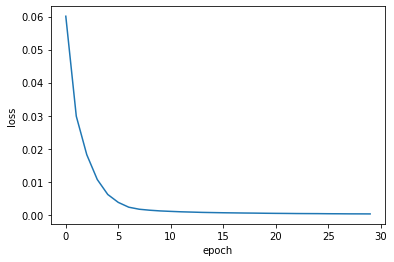

In [35]:
nn = Neural_Net(input_size, hidden_size, output_size, hidden_layer, param)

#筆記者０の学習データを用いて学習
person = '0'
input_datas = learning_datas[(person,'all')]
label_datas = learning_datas[(person,'label')]

nn.train(input_datas, label_datas, output_size)

## 2. 1で学習したニューラルネットに筆記者0の学習用データを入力して識別
__________

In [8]:
#筆記者０の学習データを識別
person = '0'
input_datas = learning_datas
nn.classification(input_datas, output_size, person)
nn.result_graph()

,パターン,正解率
あ,0,1.000
い,1,1.000
う,2,1.000
え,3,1.000
お,4,1.000
か,5,1.000
き,6,1.000
く,7,1.000
け,8,1.000
こ,9,1.000


## 3. 1で学習したニューラルネットに筆記者0のテスト用データを入力して識別
__________

In [9]:
#筆記者０のテストデータを識別
person = '0'
input_datas = test_datas
nn.classification(input_datas, output_size, person)
nn.result_graph()

,パターン,正解率
あ,0,1.000
い,1,1.000
う,2,1.000
え,3,1.000
お,4,1.000
か,5,1.000
き,6,1.000
く,7,1.000
け,8,1.000
こ,9,1.000


## 4. 1で学習したニューラルネットに筆記者1のテスト用データを入力して識別
__________

In [10]:
#筆記者１のテストデータを識別
person = '1'
input_datas = test_datas
nn.classification(input_datas, output_size, person)
nn.result_graph()

,パターン,正解率
あ,0,0.630
い,1,1.000
う,2,0.850
え,3,0.890
お,4,0.850
か,5,0.320
き,6,0.770
く,7,0.920
け,8,0.980
こ,9,0.940


## 5. 筆記者1の学習用データを用いてニューラルネットを学習
__________

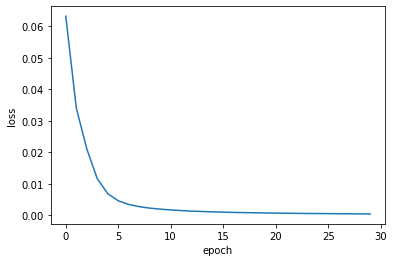

In [11]:
nn = Neural_Net(input_size, hidden_size, output_size, hidden_layer, param)

#筆記者１の学習データを用いて学習
person = '1'
input_datas = learning_datas[(person,'all')]
label_datas = learning_datas[(person,'label')]

nn.train(input_datas, label_datas, output_size)

## 6. 5で学習したニューラルネットに筆記者1の学習用データを入力して識別
__________

In [12]:
#筆記者１の学習データを識別
person = '1'
input_datas = learning_datas
nn.classification(input_datas, output_size, person)
nn.result_graph()

,パターン,正解率
あ,0,1.000
い,1,1.000
う,2,1.000
え,3,1.000
お,4,1.000
か,5,1.000
き,6,1.000
く,7,1.000
け,8,1.000
こ,9,1.000


## 7. 5で学習したニューラルネットに筆記者0のテスト用データを入力して識別
__________

In [13]:
#筆記者０のテストデータを識別
person = '0'
input_datas = test_datas
nn.classification(input_datas, output_size, person)
nn.result_graph()

,パターン,正解率
あ,0,0.670
い,1,1.000
う,2,1.000
え,3,0.980
お,4,0.800
か,5,0.430
き,6,0.480
く,7,1.000
け,8,1.000
こ,9,0.980


## 8. 5で学習したニューラルネットに筆記者1のテスト用データを入力して識別
__________

In [14]:
#筆記者１のテストデータを識別
person = '1'
input_datas = test_datas
nn.classification(input_datas, output_size, person)
nn.result_graph()

,パターン,正解率
あ,0,1.000
い,1,0.990
う,2,1.000
え,3,1.000
お,4,1.000
か,5,1.000
き,6,1.000
く,7,1.000
け,8,1.000
こ,9,1.000


## 9. 筆記者0と筆記者1の学習用データを用いてニューラルネットを学習
__________

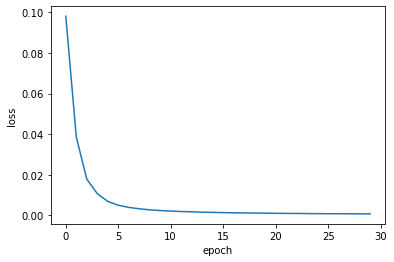

In [15]:
nn = Neural_Net(input_size, hidden_size, output_size, hidden_layer, param)

#筆記者０と筆記者１の学習データを用いて学習
people = ['0', '1']
input_datas = []
label_datas = []

for person in people:
    input_datas.extend(learning_datas[(person,'all')])
    label_datas.extend(learning_datas[(person,'label')])

nn.train(input_datas, label_datas, output_size)

## 10. 9で学習したニューラルネットに筆記者0と筆記者1の学習用データを入力して識別
__________

In [16]:
#筆記者０と筆記者１の学習データを識別
people = ['0', '1']
input_datas = {}
for i in range(output_size):
    input_datas[('0+1',i)] = []
    for person in people:
        input_datas[('0+1',i)].extend(learning_datas[(person,i)])
    input_datas[('0+1',i)] = np.array(input_datas[('0+1',i)])

nn.classification(input_datas, output_size, '0+1')
nn.result_graph()

,パターン,正解率
あ,0,1.00000
い,1,1.00000
う,2,1.00000
え,3,1.00000
お,4,1.00000
か,5,1.00000
き,6,1.00000
く,7,1.00000
け,8,1.00000
こ,9,1.00000


## 11. 9で学習したニューラルネットに筆記者0と筆記者1のテスト用データを入力して識別
__________

In [17]:
#筆記者０と筆記者１のテストデータを識別
people = ['0', '1']
input_datas = {}
for i in range(output_size):
    input_datas[('0+1',i)] = []
    for person in people:
        input_datas[('0+1',i)].extend(test_datas[(person,i)])
    input_datas[('0+1',i)] = np.array(input_datas[('0+1',i)])

nn.classification(input_datas, output_size, '0+1')
nn.result_graph()

,パターン,正解率
あ,0,1.00000
い,1,0.99500
う,2,1.00000
え,3,1.00000
お,4,0.99500
か,5,0.99500
き,6,0.99500
く,7,1.00000
け,8,1.00000
こ,9,1.00000


# <ニューラルネットの出力について>
__________

## 筆記者0の学習データで学習

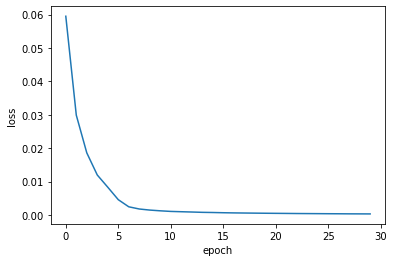

In [18]:
nn = Neural_Net(input_size, hidden_size, output_size, hidden_layer, param)

#筆記者０の学習データを用いて学習
person = '0'
input_datas = learning_datas[(person,'all')]
label_datas = learning_datas[(person,'label')]

nn.train(input_datas, label_datas, output_size)

## 筆記者１のテストデータの'あ'を識別した出力例

In [31]:
input_datas = test_datas
person = '1'
pattern = 0

_, output = nn.predict(input_datas[(person, pattern)], output_size)
print(output[1])

df = pd.DataFrame({'出力':output[1]},\
                  index=['あ','い','う','え','お','か','き','く','け','こ','さ','し','す','せ','そ','た','ち','つ','て','と'])
display(df)

[5.81707051e-01 6.92086094e-04 3.40187279e-04 7.84625814e-04
 9.73419868e-06 7.68956295e-02 2.69645614e-03 8.11583004e-05
 2.30079035e-02 1.21475487e-06 5.97506778e-04 4.78714832e-05
 2.61648919e-01 3.41630549e-03 3.55252604e-03 3.71032845e-03
 2.18427341e-01 1.01257774e-05 4.32548295e-03 8.08695985e-06]


,出力
あ,0.581707
い,0.000692
う,0.000340
え,0.000785
お,0.000010
か,0.076896
き,0.002696
く,0.000081
け,0.023008
こ,0.000001


# <正解率が低いパターンがある原因を探す>
___________

In [20]:
#筆記者１のテストデータを識別
person = '1'
input_datas = test_datas
nn.classification(input_datas, output_size, person)
nn.result_graph()

,パターン,正解率
あ,0,0.6500
い,1,1.0000
う,2,0.8500
え,3,0.8500
お,4,0.8500
か,5,0.4100
き,6,0.7700
く,7,0.8600
け,8,0.9800
こ,9,0.8900


## 正解率が低い文字を筆記者0と筆記者1で比べてみる

In [21]:
from pathlib import Path
import numpy as np
from matplotlib.font_manager import FontProperties
fp = FontProperties(fname='/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc', size=24)

In [22]:
def imshow(fig, person, pattern, x, y):
    p = Path('Data')
    d = list(p.glob("**/*"+person+"_"+pattern+"T.dat"))[0]
    data = []
    f = open(d, 'r')
    for line in f:
        data.append([ int(num) for num in line.rstrip('\n') ])
    data = np.array(data)
    
    for i in range(x):
        fig.add_subplot(y, x, i+1)
        plt.imshow(data[0+i*64:64+i*64], cmap = "gray_r", vmin=0, vmax=1)
        plt.title('筆記者'+person, fontproperties=fp)

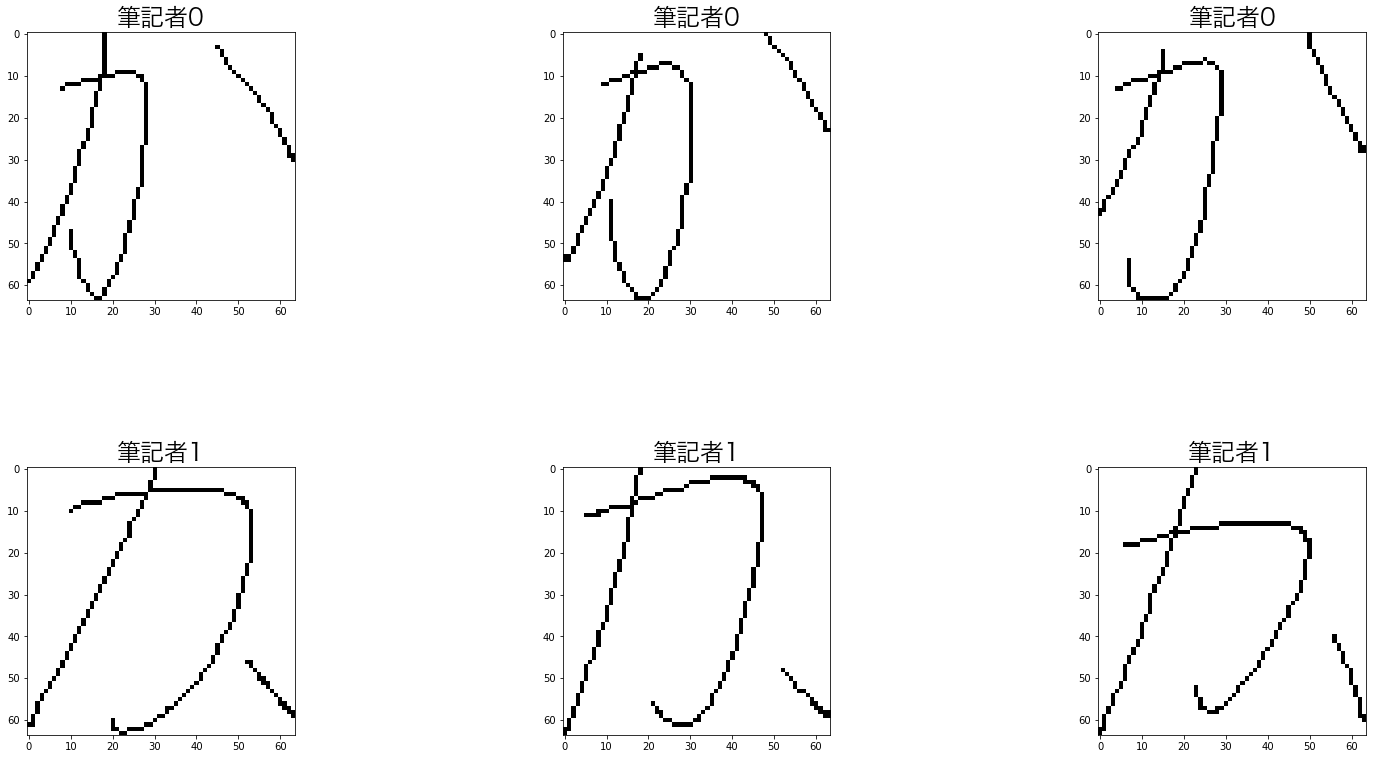

In [23]:
fig = plt.figure(figsize=(24,24))
plt.subplots_adjust(wspace=1, hspace=1)

person = '0'
pattern = '05'
imshow(fig, person, pattern, 3, 2)

person = '1'
pattern = '05'
imshow(fig, person, pattern, 3, 1)


plt.show(block=True)

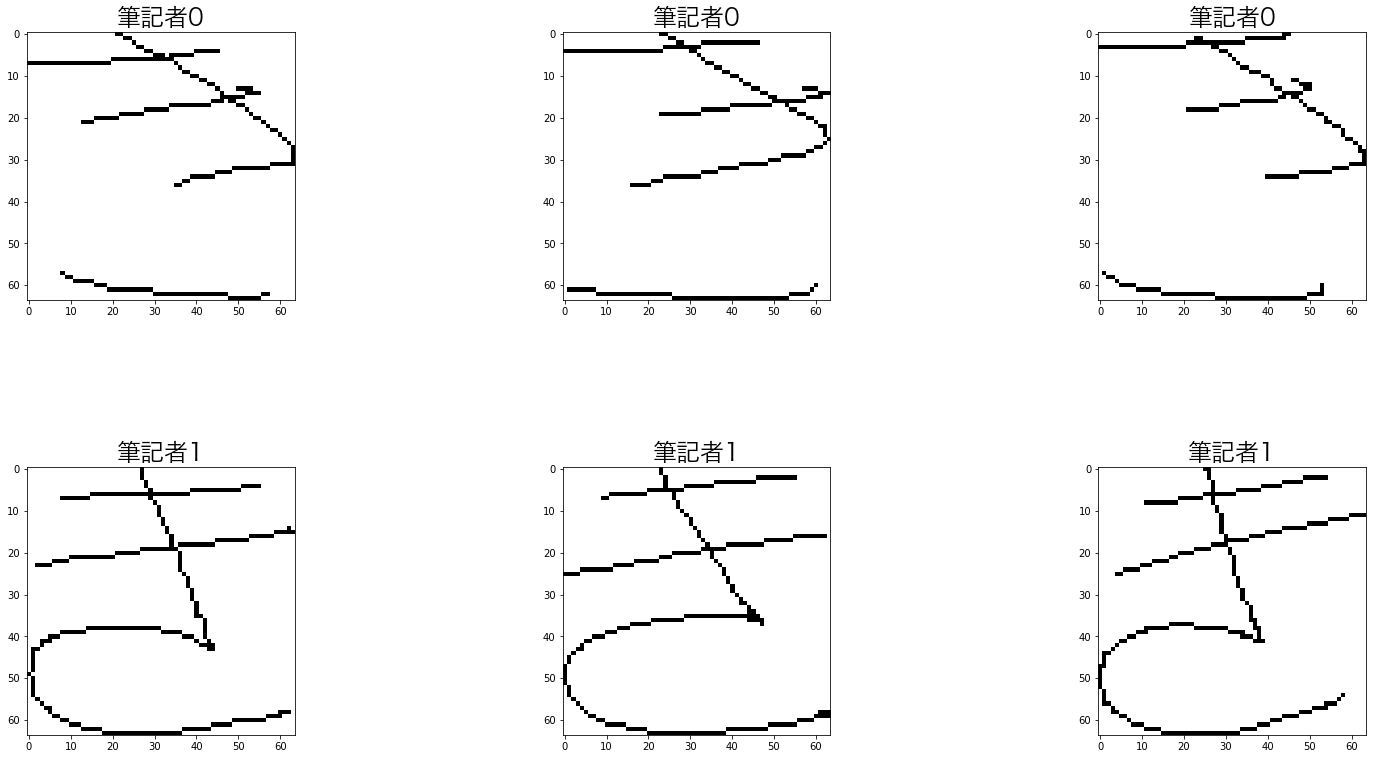

In [24]:
fig = plt.figure(figsize=(24,24))
plt.subplots_adjust(wspace=1, hspace=1)

person = '0'
pattern = '06'
imshow(fig, person, pattern, 3, 2)

person = '1'
pattern = '06'
imshow(fig, person, pattern, 3, 1)


plt.show(block=True)